# Employment Example

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import sys
import torch
sys.path.append(os.path.join(os.pardir))
from Code import nonparamcdf as npcdf
from Code import kernel
from CDTE.cdte import CQTE
from CDTE.nuisance import KernelQuantileRegressor, RBFKernel
from tqdm import tqdm

data_dir = os.path.join(os.pardir, "RealData")
plt.rc('font',**{'family':'sans-serif'})
#If fonttype = 1 doesn't work with LaTeX, try fonttype 42.
plt.rc('pdf',fonttype = 42)
plt.rc('ps',fonttype = 42)
plt.rcParams['figure.dpi'] = 140

# None vs Any with Age

In [56]:
# Read data from .dta file
EmploymentData = pd.read_stata(os.path.join(data_dir, "EmploymentData.dta"))

y = torch.tensor(EmploymentData["wageadj1_8"].to_numpy())
X = torch.tensor(EmploymentData["age"].to_numpy()).unsqueeze(-1)
a = torch.tensor(EmploymentData["emp"].to_numpy()).float()

# Take 1st 2000 observations
X = X[:2000]
y = y[:2000]
a = a[:2000]

print(torch.any(torch.isnan(y)))
print(torch.any(torch.isnan(X)))

# Split data by a
X0 = X[a == 0.,:]
X1 = X[a == 1.,:]
y0 = y[a == 0.]
y1 = y[a == 1.]
print(f"Number of y0 samples {y0.shape}")
print(f"Number of y1 samples {y1.shape}")

tensor(False)
tensor(False)
Number of y0 samples torch.Size([969])
Number of y1 samples torch.Size([1031])


In [57]:
x_test1, X_test2 = torch.split(X, 1000, dim=0)
print(torch.median(torch.linalg.norm(x_test1 - X_test2, dim=1)))

tensor(5.9562)


## CQC

In [44]:
# Set-up model
main_kernel = kernel.KGauss(sigma2=3)
    # Estimate Pseudo-Outcome Objects
adaptive_kernel = npcdf.kernel.KGauss(sigma2=.1)
est_prop_func = npcdf.kernel_regressor(adaptive_kernel, min=0.1, max=0.9)
est_prop_func.fit(a, X)
est_cdf_0 = npcdf.kernel_cdf(adaptive_kernel)
est_cdf_0.fit(y0,X0)

est_cdf_1 = npcdf.kernel_cdf(adaptive_kernel)
est_cdf_1.fit(y1, X1)

model = npcdf.dr_learner(main_kernel, est_cdf_0, est_cdf_1, est_prop_func)
model.fit(y0, X0, y1, X1)

Plot results

In [45]:
# Get 10% and 90% quantiles of y0
n_grid = 50
max_data=100
quantiles = torch.tensor([0.1, 0.9])
y0_quant = np.quantile(y0, quantiles)
X_quant = np.quantile(X, quantiles)
test_y0 = np.linspace(y0_quant[0], y0_quant[1] ,n_grid)
test_X = np.linspace(X_quant[0], X_quant[1], n_grid)

big_X, big_y = np.meshgrid(test_X, test_y0 )
big_X_flat = torch.tensor(big_X).float().reshape(-1,1)
big_y_flat = torch.tensor(big_y).float().reshape(-1)

In [37]:
outlist = []
for i in range(int(np.ceil(n_grid**2/max_data))):
    temp_out = model.predict(
        big_y_flat[i*max_data:(i+1)*max_data],
        big_X_flat[i*max_data:(i+1)*max_data,:], isotonic=True)
    outlist.append(temp_out)
results = torch.cat(outlist).reshape(n_grid, n_grid)
results_diff = (torch.cat(outlist)-big_y_flat).reshape(n_grid, n_grid)

alphas_out = est_cdf_0.cdf(big_y_flat, big_X_flat).reshape(n_grid, n_grid)

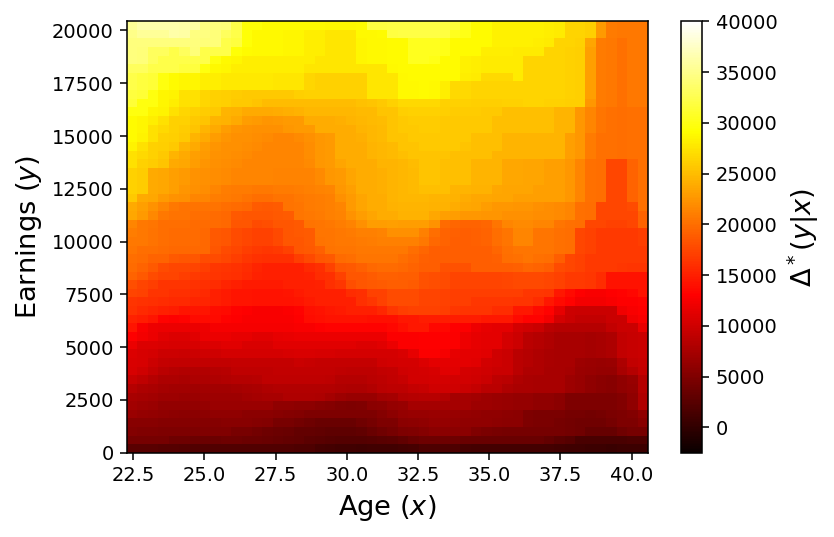

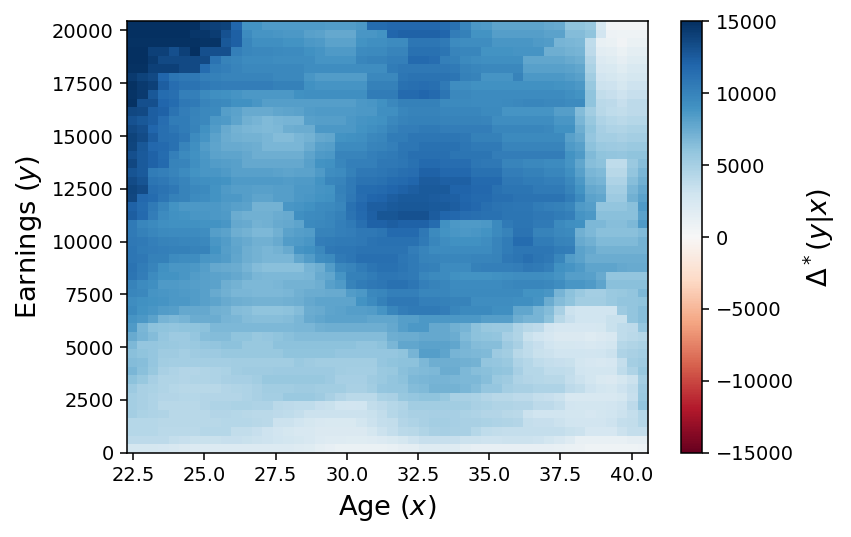

In [38]:
# Plot heatmap of the results with test_x on x-axis and test_y0 on y-axis and out as the heatmap
fig, ax = plt.subplots(figsize=(6, 4))
contour = ax.imshow(results, cmap='hot', interpolation='nearest', origin='lower',
                    extent=[X_quant[0], X_quant[1], y0_quant[0], y0_quant[1]], aspect="auto", vmin=-2500, vmax=40000)
cbar = fig.colorbar(contour).set_label(label=r"$\Delta^*(y|x)$", fontsize=14)
ax.set_xlabel(r"Age ($x$)", fontsize=14)
ax.set_ylabel(r"Earnings ($y$)", fontsize=14)
ax.set_title("")
fig.savefig("../Plots/Employment_g_hat_heatmap.pdf",bbox_inches='tight')

# cbar_ax = fig.add_axes([0.93, 0.11, 0.02, 0.775])  # Adjust these values as needed
# Use the last contour plot to generate the colorbar

fig, ax = plt.subplots(figsize=(6, 4))
contour_1 = ax.imshow(
    results_diff, cmap='RdBu', interpolation='nearest', origin='lower',
    extent=[X_quant[0], X_quant[1], y0_quant[0], y0_quant[1]], aspect="auto", vmin=-15000, vmax=15000)
cbar = fig.colorbar(contour_1).set_label(label=r"$\Delta^*(y|x)$", fontsize=14)
ax.set_xlabel(r"Age ($x$)", fontsize=14)
ax.set_ylabel(r"Earnings ($y$)", fontsize=14)
ax.set_title("")
fig.savefig("../Plots/Employment_g_hat-y_heatmap.pdf",bbox_inches='tight')

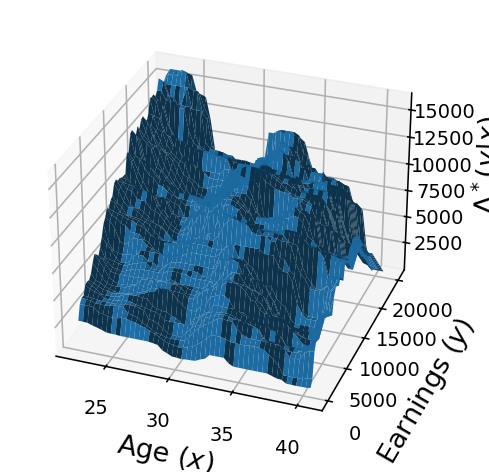

In [39]:
# Create new plot for this one
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(big_X, big_y, results_diff.numpy(), alpha=1)
# add intesecting plane at z=0 read and seethrough
# ax.plot_surface(X.numpy(), Y.numpy(), np.zeros_like(Z_g.numpy()), color="red", alpha=0.5)
ax.set_xlabel(r'Age ($x$)', fontsize=14)
ax.set_ylabel(r'Earnings $(y)$', fontsize=14, labelpad=7)
ax.set_zlabel(r'$\Delta^*(y|x)$', fontsize=14, labelpad=7)
ax.view_init(30, -70)
extra_artists = ax.get_xaxis().get_label(), ax.get_yaxis().get_label(), ax.get_zaxis().get_label()
fig.savefig("../Plots/Employment_g_hat-y_3Dplot.pdf",bbox_inches='tight', bbox_extra_artists=extra_artists)

## CQTE

In [62]:
# Set-up model
main_kernel = kernel.KGauss(sigma2=3)
    # Estimate Pseudo-Outcome Objects
adaptive_kernel = npcdf.kernel.KGauss(sigma2=.5)
est_prop_func = npcdf.kernel_regressor(adaptive_kernel, min=0.1, max=0.9)
est_prop_func.fit(a, X)
est_cdf_0 = npcdf.kernel_cdf(adaptive_kernel)
est_cdf_0.fit(y0,X0)

est_cdf_1 = npcdf.kernel_cdf(adaptive_kernel)
est_cdf_1.fit(y1, X1)

model = npcdf.dr_learner(main_kernel, est_cdf_0, est_cdf_1, est_prop_func)
model.fit(y0, X0, y1, X1)

Plot results

In [63]:
# Get 10% and 90% quantiles of y0
n_grid = 50
max_data=100
quantiles = torch.tensor([0.1, 0.9])
X_quant = np.quantile(X, quantiles)
test_X = np.linspace(X_quant[0], X_quant[1], n_grid)
test_alpha = np.linspace(quantiles[0], quantiles[1], n_grid)

big_X, big_alpha = np.meshgrid(test_X, test_alpha)
big_X_flat = torch.tensor(big_X).float().reshape(-1,1)
big_alpha_flat = torch.tensor(big_alpha).float().reshape(-1)

In [64]:
outlist = []
y_vals_list = []
for i in range(int(np.ceil(n_grid**2/max_data))):
    y_vals = est_cdf_0.inverse_cdf(
        big_alpha_flat[i*max_data:(i+1)*max_data],
        big_X_flat[i*max_data:(i+1)*max_data,:])
    temp_out = model.predict(
        y_vals, big_X_flat[i*max_data:(i+1)*max_data,:], isotonic=True)
    outlist.append(temp_out)
    y_vals_list.append(y_vals)
results = torch.cat(outlist).reshape(n_grid, n_grid)
results_diff = (torch.cat(outlist)-torch.cat(y_vals_list)).reshape(n_grid, n_grid)


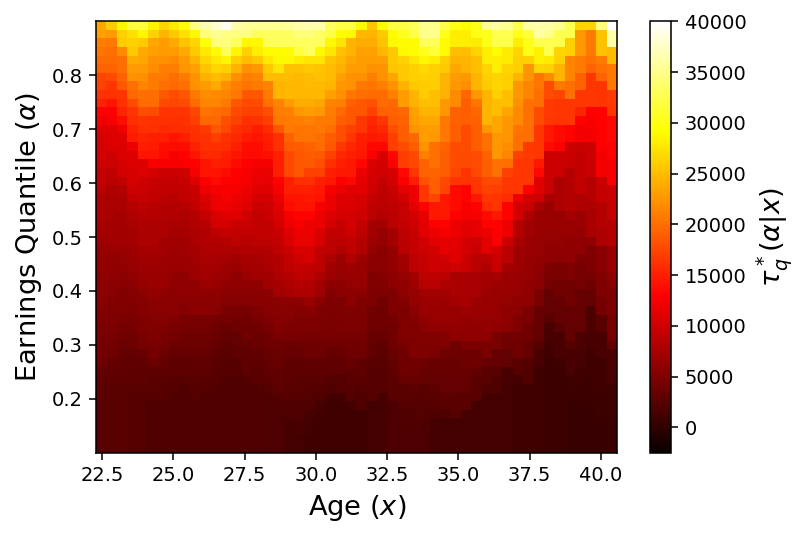

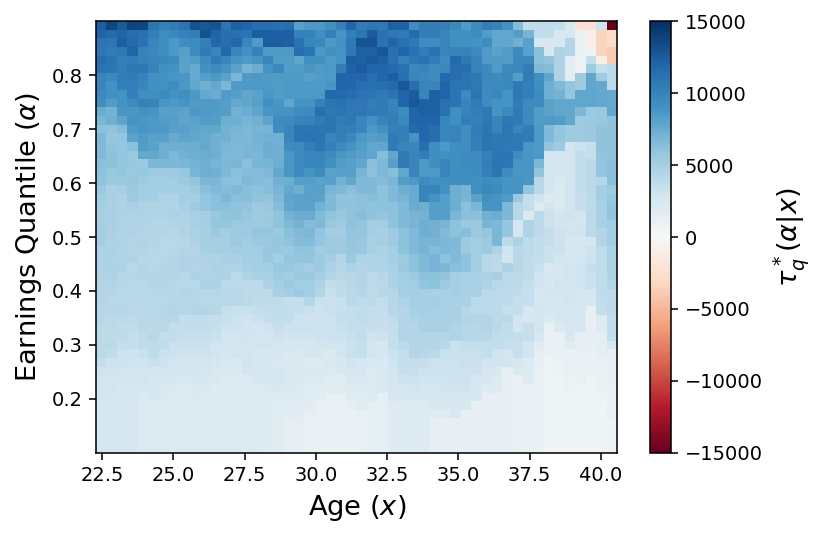

In [65]:
# Plot heatmap of the results with test_x on x-axis and test_y0 on y-axis and out as the heatmap
fig, ax = plt.subplots(figsize=(6, 4))
contour = ax.imshow(results, cmap='hot', interpolation='nearest', origin='lower',
                    extent=[X_quant[0], X_quant[1], quantiles[0], quantiles[1]], aspect="auto", vmin=-2500, vmax=40000)
cbar = fig.colorbar(contour).set_label(label=r"$\tau^*_q(\alpha|x)$", fontsize=14)
ax.set_xlabel(r"Age ($x$)", fontsize=14)
ax.set_ylabel(r"Earnings Quantile ($\alpha$)", fontsize=14)
ax.set_title("")
fig.savefig("../Plots/Employment_cqte_heatmap.pdf",bbox_inches='tight')

# cbar_ax = fig.add_axes([0.93, 0.11, 0.02, 0.775])  # Adjust these values as needed
# Use the last contour plot to generate the colorbar

fig, ax = plt.subplots(figsize=(6, 4))
contour_1 = ax.imshow(
    results_diff, cmap='RdBu', interpolation='nearest', origin='lower',
    extent=[X_quant[0], X_quant[1], quantiles[0], quantiles[1]], aspect="auto", vmin=-15000, vmax=15000)
cbar = fig.colorbar(contour_1).set_label(label=r"$\tau^*_q(\alpha|x)$", fontsize=14)
ax.set_xlabel(r"Age ($x$)", fontsize=14)
ax.set_ylabel(r"Earnings Quantile ($\alpha$)", fontsize=14)
ax.set_title("")
fig.savefig("../Plots/Employment_cqte_heatmap.pdf",bbox_inches='tight')

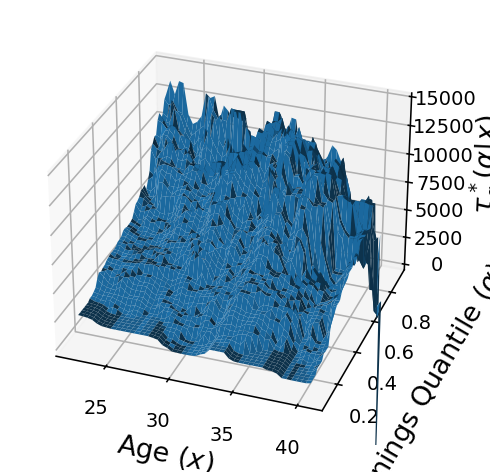

In [68]:
# Create new plot for this one
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(big_X, big_alpha, results_diff.numpy(), alpha=1)
# add intesecting plane at z=0 read and seethrough
# ax.plot_surface(X.numpy(), Y.numpy(), np.zeros_like(Z_g.numpy()), color="red", alpha=0.5)
ax.set_xlabel(r'Age ($x$)', fontsize=14)
ax.set_ylabel(r'Earnings Quantile $(\alpha)$', fontsize=14, labelpad=7)
ax.set_zlabel(r'$\tau_q^*(\alpha|x)$', fontsize=14, labelpad=7)
ax.set_zlim(-200, 15000)
ax.view_init(30, -70)
extra_artists = ax.get_xaxis().get_label(), ax.get_yaxis().get_label(), ax.get_zaxis().get_label()
fig.savefig("../Plots/Employment_cqte_3Dplot.pdf",bbox_inches='tight', bbox_extra_artists=extra_artists)

alternatively getting the alpahs for each x,y pair

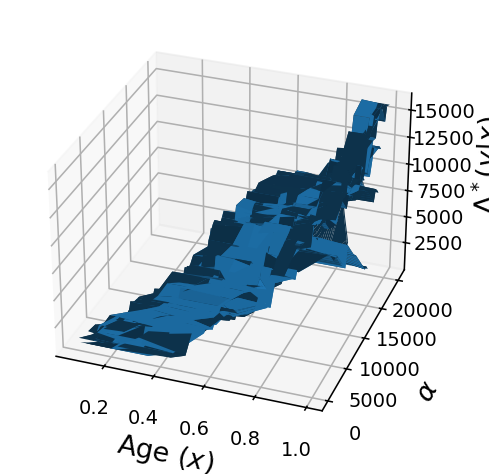

In [40]:
# Create new plot for this one
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alphas_out, big_y, results_diff.numpy(), alpha=1)
# add intesecting plane at z=0 read and seethrough
# ax.plot_surface(X.numpy(), Y.numpy(), np.zeros_like(Z_g.numpy()), color="red", alpha=0.5)
ax.set_xlabel(r'Age ($x$)', fontsize=14)
ax.set_ylabel(r'$\alpha$', fontsize=14, labelpad=7)
ax.set_zlabel(r'$\Delta^*(y|x)$', fontsize=14, labelpad=7)
ax.view_init(30, -70)
extra_artists = ax.get_xaxis().get_label(), ax.get_yaxis().get_label(), ax.get_zaxis().get_label()
# fig.savefig("../Plots/Employment_g_hat-y_3Dplot.pdf",bbox_inches='tight', bbox_extra_artists=extra_artists)

# Plot CQTE

## CQTE approach

In [17]:
# Set-up model
main_kernel = kernel.KGauss(sigma2=3)
    # Estimate Pseudo-Outcome Objects
adaptive_kernel = npcdf.kernel.KGauss(sigma2=.5)
propensity_model = npcdf.kernel_regressor_numpy(adaptive_kernel, min=0.1, max=0.9)


def exp_kernel_generator(h=1):
    return lambda x: 1/h * np.exp(-x**2/h**2/2)
cond_density_kernel = exp_kernel_generator(h=1)
#cond_density_model = Lasso(alpha=0.05)
cond_density_model = RandomForestRegressor(
    n_estimators=50, max_depth=5, min_samples_leaf=5, min_samples_split=10)

cqte_model = npcdf.kernel_regressor_numpy(main_kernel)

n_grid=50
quantiles = torch.tensor([0.1, 0.9])
alphas = np.linspace(*quantiles, n_grid)
X_quant = np.quantile(X, quantiles)
test_X = np.linspace(X_quant[0], X_quant[1], 100).reshape(-1,1)
cqte_list = []
for alpha in tqdm(alphas):
    quantile_model = KernelQuantileRegressor(
        kernel=RBFKernel(scale=np.sqrt(.5)/2),
        tau=alpha)
    CQTE_est = CQTE(
        propensity_model=propensity_model, 
        quantile_model=quantile_model,
        cond_density_kernel=cond_density_kernel,
        cond_density_model=cond_density_model,
        cqte_model=cqte_model, 
        tau=alpha, cv=2)
    CQTE_est.fit(X.numpy(), a.numpy(), y.numpy())
    cqte_list.append(CQTE_est.effect(test_X))


cqte_out = np.stack(cqte_list, axis=0)
X_grid = np.tile(test_X.reshape(1,-1),(50,1))
alpha_grid=np.tile(alphas.reshape(-1,1), (1,100)) 


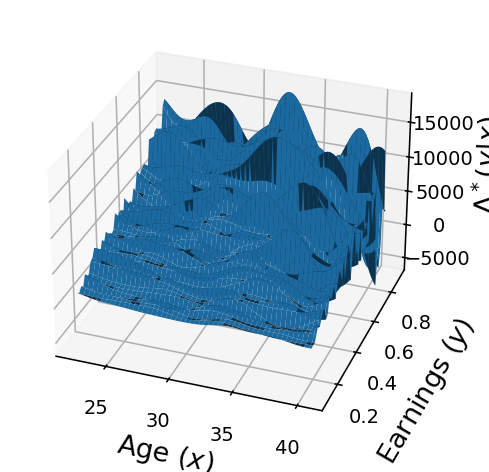

In [31]:
# Create new plot for this one
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_grid, alpha_grid, cqte_out, alpha=1)
# add intesecting plane at z=0 read and seethrough
# ax.plot_surface(X.numpy(), Y.numpy(), np.zeros_like(Z_g.numpy()), color="red", alpha=0.5)
ax.set_xlabel(r'Age ($x$)', fontsize=14)
ax.set_ylabel(r'Earnings $(y)$', fontsize=14, labelpad=7)
ax.set_zlabel(r'$\Delta^*(y|x)$', fontsize=14, labelpad=7)
ax.view_init(30, -70)
extra_artists = ax.get_xaxis().get_label(), ax.get_yaxis().get_label(), ax.get_zaxis().get_label()
# fig.savefig("../Plots/Employment_g_hat-y_3Dplot.pdf",bbox_inches='tight', bbox_extra_artists=extra_artists)

# None vs Temporary Job

In [9]:
# Read data from .dta file
EmploymentData = pd.read_stata(os.path.join(data_dir, "EmploymentData.dta"))
# Filter out registered employment cases to just look at temporary vs none
EmploymentData = EmploymentData[EmploymentData["regemp"]==0]

y = torch.tensor(EmploymentData["wageadj1_8"].to_numpy())
X = torch.tensor(EmploymentData["age"].to_numpy()).unsqueeze(-1)
a = torch.tensor(EmploymentData["tempemp"].to_numpy()).float()

# Take 1st 2000 observations
X = X[:2000]
y = y[:2000]
a = a[:2000]

print(torch.any(torch.isnan(y)))
print(torch.any(torch.isnan(X)))

# Split data by a
X0 = X[a == 0.,:]
X1 = X[a == 1.,:]
y0 = y[a == 0.]
y1 = y[a == 1.]
print(f"Number of y0 samples {y0.shape}")
print(f"Number of y1 samples {y1.shape}")

tensor(False)
tensor(False)
Number of y0 samples torch.Size([1666])
Number of y1 samples torch.Size([334])


In [10]:
x_test1, X_test2 = torch.split(X, 1000, dim=0)
print(torch.median(torch.linalg.norm(x_test1 - X_test2, dim=1)))

tensor(6.4274)


In [11]:
# Set-up model
main_kernel = kernel.KGauss(sigma2=3)
    # Estimate Pseudo-Outcome Objects
adaptive_kernel = npcdf.kernel.KGauss(sigma2=.1)
est_prop_func = npcdf.kernel_regressor(adaptive_kernel, min=0.1, max=0.9)
est_prop_func.fit(a, X)
est_cdf_0 = npcdf.kernel_cdf(adaptive_kernel)
est_cdf_0.fit(y0,X0)

est_cdf_1 = npcdf.kernel_cdf(adaptive_kernel)
est_cdf_1.fit(y1, X1)

model = npcdf.dr_learner(main_kernel, est_cdf_0, est_cdf_1, est_prop_func)
model.fit(y0, X0, y1, X1)

Plot results

In [12]:
# Get 10% and 90% quantiles of y0
n_grid = 50
max_data=100
quantiles = torch.tensor([0.1, 0.9])
y0_quant = np.quantile(y0, quantiles)
X_quant = np.quantile(X, quantiles)
test_y0 = np.linspace(y0_quant[0], y0_quant[1] ,n_grid)
test_X = np.linspace(X_quant[0], X_quant[1], n_grid)

big_X, big_y = np.meshgrid(test_X, test_y0 )
big_X_flat = torch.tensor(big_X).float().reshape(-1,1)
big_y_flat = torch.tensor(big_y).float().reshape(-1)

In [13]:
outlist = []
for i in range(int(np.ceil(n_grid**2/max_data))):
    temp_out = model.predict(
        big_y_flat[i*max_data:(i+1)*max_data],
        big_X_flat[i*max_data:(i+1)*max_data,:], isotonic=True)
    outlist.append(temp_out)
results = torch.cat(outlist).reshape(n_grid, n_grid)
results_diff = (torch.cat(outlist)-big_y_flat).reshape(n_grid, n_grid)

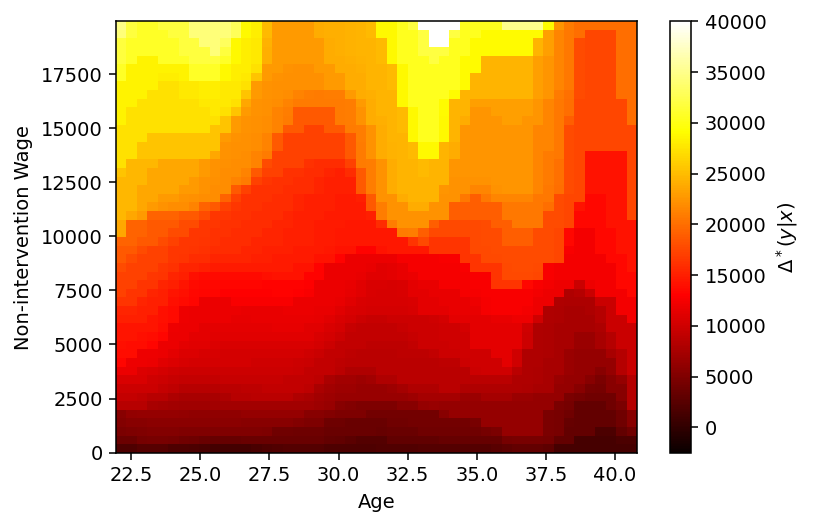

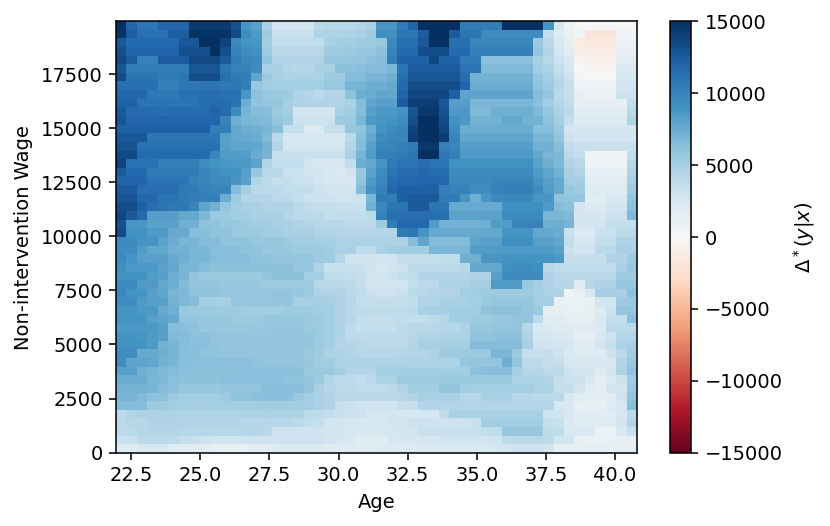

In [14]:
# Plot heatmap of the results with test_x on x-axis and test_y0 on y-axis and out as the heatmap
fig, ax = plt.subplots(figsize=(6, 4))
contour = ax.imshow(results, cmap='hot', interpolation='nearest', origin='lower',
                    extent=[X_quant[0], X_quant[1], y0_quant[0], y0_quant[1]], aspect="auto", vmin=-2500, vmax=40000)
fig.colorbar(contour, label=r"$\Delta^*(y|x)$")
ax.set_xlabel("Age")
ax.set_ylabel("Non-intervention Wage")
ax.set_title("")
fig.savefig("../Plots/Employment_temporary_g_hat_heatmap.pdf",bbox_inches='tight')

# cbar_ax = fig.add_axes([0.93, 0.11, 0.02, 0.775])  # Adjust these values as needed
# Use the last contour plot to generate the colorbar

fig, ax = plt.subplots(figsize=(6, 4))
contour_1 = ax.imshow(
    results_diff, cmap='RdBu', interpolation='nearest', origin='lower',
    extent=[X_quant[0], X_quant[1], y0_quant[0], y0_quant[1]], aspect="auto", vmin=-15000, vmax=15000)
fig.colorbar(contour_1).set_label(label=r"$\Delta^*(y|x)$")
ax.set_xlabel("Age")
ax.set_ylabel("Non-intervention Wage")
ax.set_title("")
fig.savefig("../Plots/Employment_temporary_g_hat-y_heatmap.pdf",bbox_inches='tight')

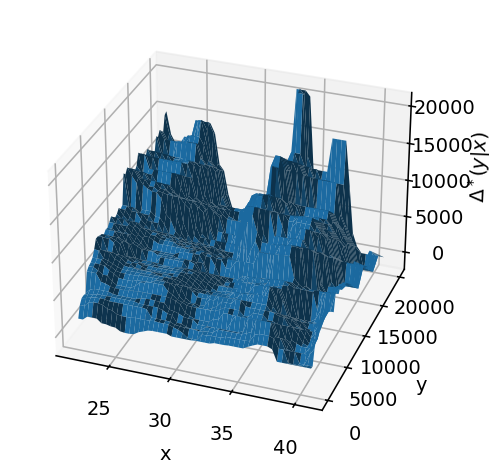

In [15]:
# Create new plot for this one
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(big_X, big_y, results_diff.numpy(), alpha=1)
# add intesecting plane at z=0 read and seethrough
# ax.plot_surface(X.numpy(), Y.numpy(), np.zeros_like(Z_g.numpy()), color="red", alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\Delta^*(y|x)$')
ax.view_init(30, -70)
fig.savefig("../Plots/Employment_temporary_g_hat-y_3Dplot.pdf",bbox_inches='tight')

# None vs Registered Job

In [16]:
# Read data from .dta file
EmploymentData = pd.read_stata(os.path.join(data_dir, "EmploymentData.dta"))
# Filter out registered employment cases to just look at temporary vs none
EmploymentData = EmploymentData[EmploymentData["tempemp"]==0]
y = torch.tensor(EmploymentData["wageadj1_8"].to_numpy())
X = torch.tensor(EmploymentData["age"].to_numpy()).unsqueeze(-1)
a = torch.tensor(EmploymentData["regemp"].to_numpy()).float()

# Take 1st 2000 observations
X = X[:2000]
y = y[:2000]
a = a[:2000]

print(torch.any(torch.isnan(y)))
print(torch.any(torch.isnan(X)))

# Split data by a
X0 = X[a == 0.,:]
X1 = X[a == 1.,:]
y0 = y[a == 0.]
y1 = y[a == 1.]
print(f"Number of y0 samples {y0.shape}")
print(f"Number of y1 samples {y1.shape}")

tensor(False)
tensor(False)
Number of y0 samples torch.Size([1100])
Number of y1 samples torch.Size([900])


In [17]:
x_test1, X_test2 = torch.split(X, 1000, dim=0)
print(torch.median(torch.linalg.norm(x_test1 - X_test2, dim=1)))

tensor(6.3918)


In [18]:
# Set-up model
main_kernel = kernel.KGauss(sigma2=3)
    # Estimate Pseudo-Outcome Objects
adaptive_kernel = npcdf.kernel.KGauss(sigma2=.1)
est_prop_func = npcdf.kernel_regressor(adaptive_kernel, min=0.1, max=0.9)
est_prop_func.fit(a, X)
est_cdf_0 = npcdf.kernel_cdf(adaptive_kernel)
est_cdf_0.fit(y0,X0)

est_cdf_1 = npcdf.kernel_cdf(adaptive_kernel)
est_cdf_1.fit(y1, X1)

model = npcdf.dr_learner(main_kernel, est_cdf_0, est_cdf_1, est_prop_func)
model.fit(y0, X0, y1, X1)

Plot results

In [19]:
# Get 10% and 90% quantiles of y0
n_grid = 50
max_data=100
quantiles = torch.tensor([0.1, 0.9])
y0_quant = np.quantile(y0, quantiles)
X_quant = np.quantile(X, quantiles)
test_y0 = np.linspace(y0_quant[0], y0_quant[1] ,n_grid)
test_X = np.linspace(X_quant[0], X_quant[1], n_grid)

big_X, big_y = np.meshgrid(test_X, test_y0 )
big_X_flat = torch.tensor(big_X).float().reshape(-1,1)
big_y_flat = torch.tensor(big_y).float().reshape(-1)

In [20]:
outlist = []
for i in range(int(np.ceil(n_grid**2/max_data))):
    temp_out = model.predict(
        big_y_flat[i*max_data:(i+1)*max_data],
        big_X_flat[i*max_data:(i+1)*max_data,:], isotonic=True)
    outlist.append(temp_out)
results = torch.cat(outlist).reshape(n_grid, n_grid)
results_diff = (torch.cat(outlist)-big_y_flat).reshape(n_grid, n_grid)

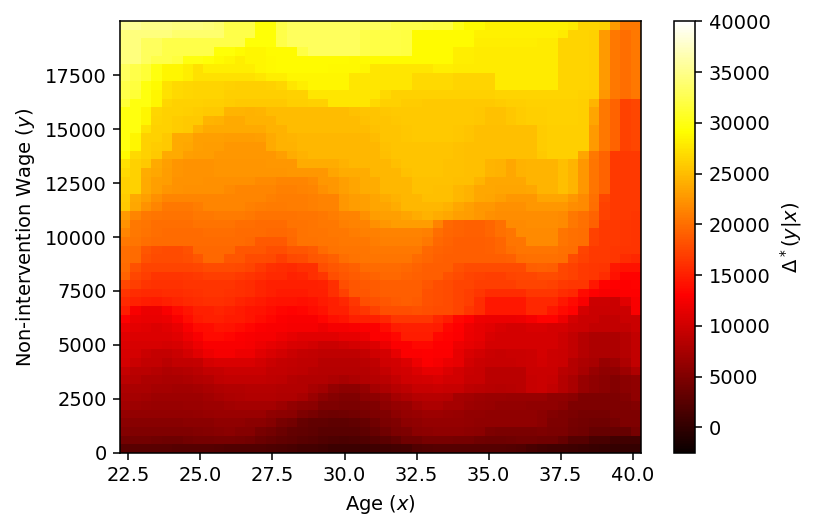

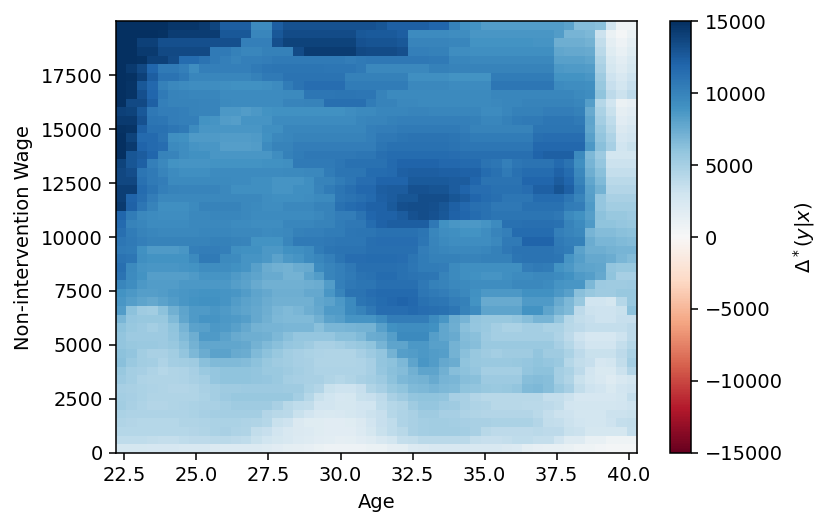

In [24]:
# Plot heatmap of the results with test_x on x-axis and test_y0 on y-axis and out as the heatmap
fig, ax = plt.subplots(figsize=(6, 4))
contour = ax.imshow(results, cmap='hot', interpolation='nearest', origin='lower',
                    extent=[X_quant[0], X_quant[1], y0_quant[0], y0_quant[1]], aspect="auto", vmin=-2500, vmax=40000)
fig.colorbar(contour, label=r"$\Delta^*(y|x)$")
ax.set_xlabel(r"Age ($x$)")
ax.set_ylabel(r"Non-intervention Wage ($y$)")
ax.set_title("")
fig.savefig("../Plots/Employment_registered_g_hat_heatmap.pdf",bbox_inches='tight')

# cbar_ax = fig.add_axes([0.93, 0.11, 0.02, 0.775])  # Adjust these values as needed
# Use the last contour plot to generate the colorbar

fig, ax = plt.subplots(figsize=(6, 4))
contour_1 = ax.imshow(
    results_diff, cmap='RdBu', interpolation='nearest', origin='lower',
    extent=[X_quant[0], X_quant[1], y0_quant[0], y0_quant[1]], aspect="auto", vmin=-15000, vmax=15000)
fig.colorbar(contour_1).set_label(label=r"$\Delta^*(y|x)$")
ax.set_xlabel("Age")
ax.set_ylabel("Non-intervention Wage")
ax.set_title("")
fig.savefig("../Plots/Employment_registered_g_hat-y_heatmap.pdf",bbox_inches='tight')

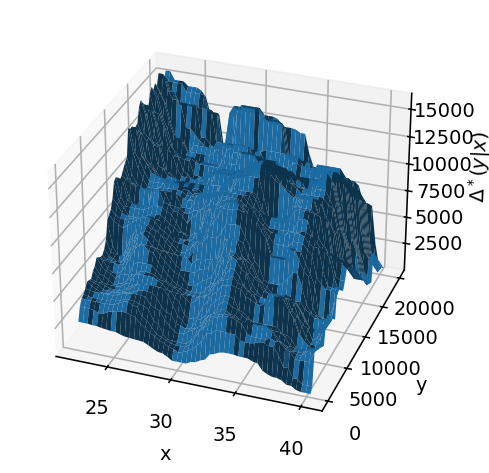

In [22]:
# Create new plot for this one
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(big_X, big_y, results_diff.numpy(), alpha=1)
# add intesecting plane at z=0 read and seethrough
# ax.plot_surface(X.numpy(), Y.numpy(), np.zeros_like(Z_g.numpy()), color="red", alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$\Delta^*(y|x)$')
ax.view_init(30, -70)
fig.savefig("../Plots/Employment_registered_g_hat-y_3Dplot.pdf",bbox_inches='tight')